# Tutorial demonstrating verification of v1 1000hPa temp against jra55

#### Import pyLatte package

In [1]:
from pylatte import utils
from pylatte import skill

#### Currently, the following packages are required to load the data - this process will be replaced by the CAFE cookbook

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

#### Import some plotting packages and widgets

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings    
warnings.filterwarnings("ignore")

# Jupyter specific -----
from ipywidgets import FloatProgress
%matplotlib inline

# A note about the methodology of pyLatte
The pyLatte package is constructed around the xarray Python package. This is particularly useful for verification computations which require large numbers of samples (different model runs) to converge. 

The approach here is to generate very large xarray objects that reference all data required for the verification, but do not store the data in memory. Operations are performed on these xarray objects out-of-memory. When it is necessary to perform a compute (e.g. to produce a plot), this is distributed over multiple processors using the dask Python package.

# Initialise dask (currently not working on vm31)

In [4]:
# import dask
# import distributed
# client = distributed.Client(local_dir='/tmp/squ027-dask-worker-space', n_workers=4)
# client

# Construct xarray objects for forecasts and observations
(The CAFE cookbook should replace many of these code blocks)

In [5]:
# Location of forecast data -----
fcst_folder = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/'
fcst_filename = 'atmos_daily*'
fcst_variable = 'temp'

# Location of observation data -----
obsv_folder = '/OSM/CBR/OA_DCFP/data/observations/jra55/isobaric/011_tmp/cat/'
obsv_filename = 'jra.55.tmp.1000.1958010100_2016123118.nc'
obsv_variable = 'TMP_GDS0_ISBL'

In [6]:
# Initial dates to include (takes approximately 1 min 30 sec per date) -----
init_dates = pd.date_range('2003-1','2013-1' , freq='1MS')

# Ensembles to include -----
ensembles = range(1,12)

# Forecast length -----
FCST_LENGTH = 2 # years

In [7]:
# Resampling details -----
resample_freq = 'MS'

### Construct forecasts xarray object
Note, dask has a known bug that manifests when trying to concatentate data containing timedelta64 arrays (see https://github.com/pydata/xarray/issues/1952 for further details). For example, try to concatenate the following two Datasets:

`In : path = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/yr2002/mn7/'`

`In : ens5 = xr.open_mfdataset(path + 'OUTPUT.5/atmos_daily*.nc', autoclose=True)`

`In : ens6 = xr.open_mfdataset(path + 'OUTPUT.6/atmos_daily*.nc', autoclose=True)`

`In : xr.concat([ens5, ens6],'ensemble')`

`Out : TypeError: invalid type promotion`

The error here is actually caused by the variables `average_DT` and `time_bounds`, which are timedelta64 arrays. However, I still do not fully unstand the bug: concatenation of `ens4` and `ens5`, for example, works fine, even though `ens4` also contains the timedelta64 variables `average_DT` and `time_bounds`. Regardless, because of this bug, it is not possible currently to create an xarray Dataset object containing all model variables. Instead, only the variable of interest (i.e. `fcst_variable` and `obsv_variable`) are retained in the concatenated xarray object.

In [8]:
# Instantiate progress bar -----
f = FloatProgress(min=0, max=len(init_dates)*len(ensembles), description='Loading...') 
display(f)

# Loop over initial dates -----
fcst_list = []
for init_date in init_dates:
    year = init_date.year
    month = init_date.month
    
    # Loop over ensembles -----
    ens_list = []
    for ensemble in ensembles:
        # Signal to increment the progress bar -----
        f.value += 1 
        
        # Stack ensembles into a list -----
        path = fcst_folder + '/yr' + str(year) + '/mn' + str(month) + \
               '/OUTPUT.' + str(ensemble) + '/' + fcst_filename + '.nc'
        dataset = xr.open_mfdataset(path, autoclose=True)[fcst_variable]
        ens_list.append(dataset.resample(time=resample_freq) \
                               .mean(dim='time'))
        
    # Concatenate ensembles -----
    ens_object = xr.concat(ens_list, dim='ensemble')
    ens_object['ensemble'] = ensembles
    
    # Stack concatenated ensembles into a list for each initial date -----                       
    fcst_list.append(utils.datetime_to_leadtime(ens_object))

# Keep track of the lead time for each initialization -----
n_lead_time = [len(x.lead_time) for x in fcst_list]

# Concatenate initial dates -----
da_fcst = xr.concat(fcst_list, dim='init_date')

# Rechunk for chunksizes of at least 1,000,000 elements -----
da_fcst = utils.prune(da_fcst.chunk(chunks={'ensemble' : len(da_fcst.ensemble), 
                                            'lead_time' : len(da_fcst.lead_time)}).squeeze())

FloatProgress(value=0.0, description='Loading...', max=1331.0)

#### Truncate the forecast lead times at 2 years
The January and July forecasts are run for 5 years rather than 2 years. The xarray concatenation above can deal with this, but fills the shorter forecasts with nans for lead times longer than 2 years. Let's get rid of some of these nans by truncating the forecasts at the lead time corresponding to the longest 2 year forecast.

In [9]:
max_increments = FCST_LENGTH * 12
n_trunc = max([i for i in n_lead_time if i <= max_increments])
da_fcst = da_fcst.isel(lead_time=range(n_trunc))

### Construct observations xarray object

In [10]:
# Instantiate progress bar -----
f = FloatProgress(min=0, max=1, description='Loading...') 
display(f)

# JRA temperature fields are only save in a time-concatenated form -----
path = obsv_folder + obsv_filename
dataset = xr.open_mfdataset(path, autoclose=True)[obsv_variable]
da_obsv = dataset.rename(fcst_variable) \
                 .rename({'initial_time0_hours' : 'time', 'g0_lon_3' : 'lon', 'g0_lat_2' : 'lat'}) \
                 .resample(time=resample_freq) \
                 .mean(dim='time')

# Stack by initial date to match forecast structure -----
da_obsv = utils.stack_by_init_date(da_obsv,da_fcst.init_date.values,n_trunc)
f.value += 1

# Average over forecast dimension if it is exists -----
if 'forecast_time1' in da_obsv.coords:
    da_obsv = da_obsv.mean(dim='forecast_time1')

# Rechunk for chunksizes of at least 1,000,000 elements -----
da_obsv = utils.prune(da_obsv.chunk(chunks={'init_date' : len(da_obsv.init_date)}).squeeze())

FloatProgress(value=0.0, description='Loading...', max=1.0)

# Let's look at temperature at 1000 hPa averaged over Australia

##### Extract forecast and observation over region
Note, we `compute()` the xarray objects here to save time later on. Once dask is working, it will probably be most sensible to leave the objects uncomputed.

Note also that we use a box here to represent Australia. Ideally, we should use a masked. Functionality for masking will be added to pyLatte in the future.

In [11]:
with utils.timer():
    # Region of interest -----
    region = (-38.0, -11.0, 113.0 , 153.0) # (lat_min,lat_max,lon_min,lon_max)

    da_fcst = utils.calc_boxavg_latlon(da_fcst.sel(pfull=1000,method='nearest',drop=True), region).compute() - 273.15
    da_obsv = utils.calc_boxavg_latlon(da_obsv, region).compute() - 273.15

   Elapsed: 24974.948425531387 sec


##### Load climatology data
Various climatologies are/will be accessable using `utils.load_climatology()`. Here we use a climatology computed over the full 55 year jra reanalysis

In [496]:
jra_clim = utils.load_climatology('jra_1958-2016', 'temp', freq='MS')

da_jra_clim = utils.calc_boxavg_latlon(jra_clim.sel(pfull=1000,method='nearest',drop=True), region).compute() - 273.15

##### Compute anomaly data
Recall that the forecast and observation data are saved as functions of lead time and initial date. The function `utils.anomalize()` computes anomalies given data and a climatology which each have a datetime dimension `time`. Thus it is necessary to first convert from the lead time/initial date format to a datetime format, then compute the anomaly, the convert back to the lead time/initial date format. The functions `utils.datetime_to_leadtime()` and `utils.leadtime_to_datetime()` enable these types of operations

In [497]:
anomalize = lambda data, clim: utils.datetime_to_leadtime(
                                   utils.anomalize(
                                       utils.leadtime_to_datetime(data),clim))

In [498]:
da_fcst_anom = da_fcst.groupby('init_date').apply(anomalize, clim=da_jra_clim)

da_obsv_anom = da_obsv.groupby('init_date').apply(anomalize, clim=da_jra_clim)

##### Compute persistence data
This requires repeating the data at the first lead time over all lead times. `utils.repeat_data()` allows us to do this

In [499]:
da_pers = utils.repeat_data(da_obsv,'lead_time')

##### Compute climatogoloy in lead time/inital date format
This is really just for convenience below

In [500]:
da_clim = (0 * da_obsv).groupby('init_date').apply(anomalize, clim=-da_jra_clim)

## Before computing any metrics, lets make some example plots

##### Plot the forecast ensembles and observations for the first initial date

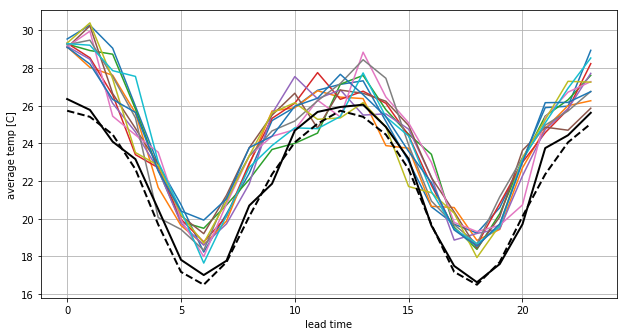

In [525]:
fig1 = plt.figure(figsize=(10,5))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(da_fcst['lead_time'],da_fcst.isel(init_date=[0]).squeeze().transpose())
ax.plot(da_obsv['lead_time'],da_obsv.isel(init_date=[0]).squeeze(),'k-',linewidth=2)
ax.plot(da_clim['lead_time'],da_clim.isel(init_date=[0]).squeeze(),'k--',linewidth=2)
ax.set_xlabel('lead time')
ax.set_ylabel('average temp [C]');

##### Plot the forecast ensembles and observations for the first initial date

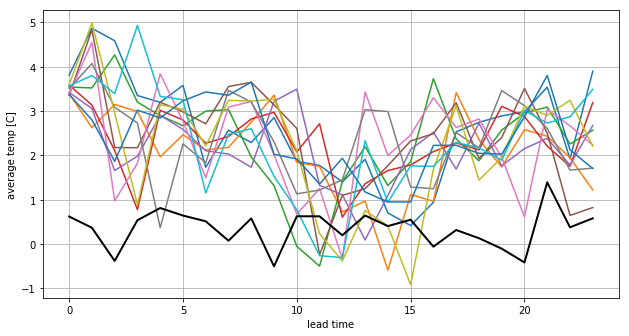

In [502]:
fig1 = plt.figure(figsize=(10,5))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(da_fcst['lead_time'],da_fcst_anom.isel(init_date=[0]).squeeze().transpose())
ax.plot(da_obsv['lead_time'],da_obsv_anom.isel(init_date=[0]).squeeze(),'k-',linewidth=2)
ax.set_xlabel('lead time')
ax.set_ylabel('average temp [C]');

# Skill metrics for probabilistic forecasts

Note, currently we only have access to the mean climatology - i.e. we cannot yet determine climatological probabilities. I plan to instead load saved fields of the climatological PDFs which will enable climatological probabilities to be computed for any user-specified event

## Rank histogram

### Rank the data and compute histograms as a function of lead time

In [503]:
with utils.timer():
    rank_histogram = skill.compute_rank_histogram(da_fcst, da_obsv, over_dims='init_date')

   Elapsed: 0.05538773536682129 sec


   Elapsed: 0.840524435043335 sec


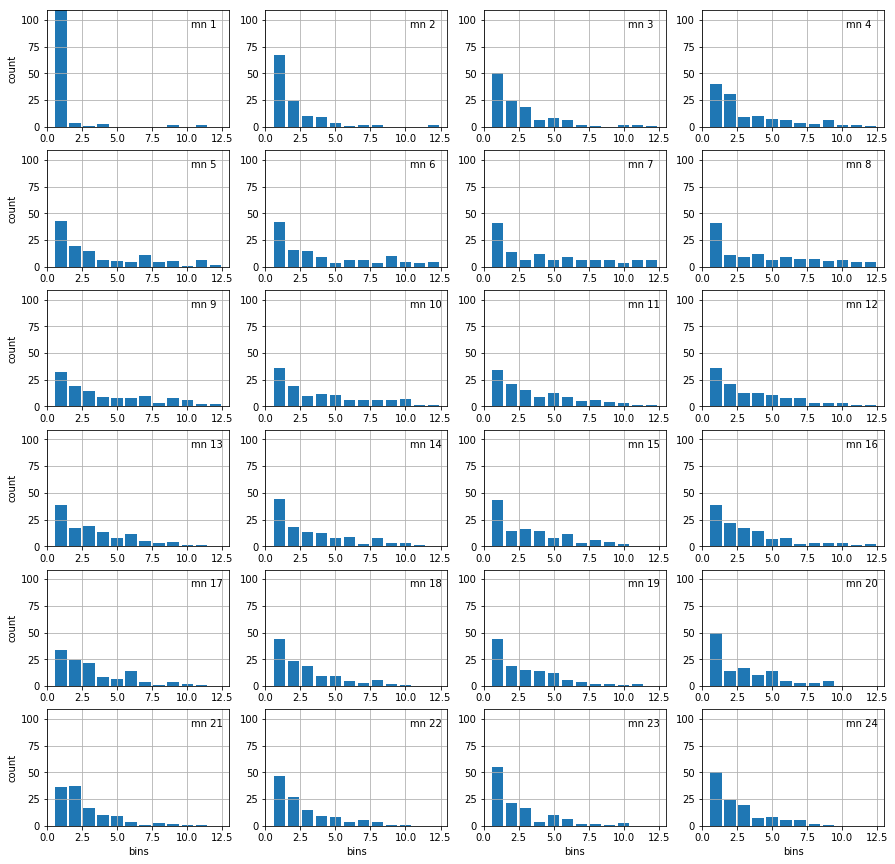

In [504]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(da_fcst.lead_time)/ncol));
    fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        ax.bar(rank_histogram.bins,rank_histogram.isel(lead_time=idx, drop=True))
        ax.set_ylim(0,rank_histogram.max())
        ax.text(10.3,0.85*rank_histogram.max(),'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('count')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('bins')

### Rank the data and compute histograms for all lead times

In [505]:
with utils.timer():
    rank_histogram = skill.compute_rank_histogram(da_fcst, da_obsv, over_dims=('init_date','lead_time'))

   Elapsed: 0.00853729248046875 sec


   Elapsed: 0.035956382751464844 sec


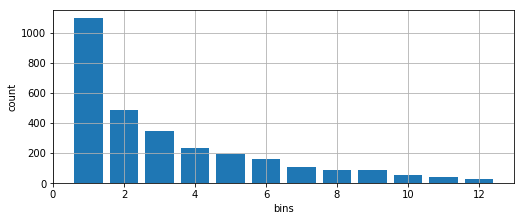

In [506]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,3))

    ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax1.grid()
    ax1.bar(rank_histogram.bins,rank_histogram)
    ax1.set_xlabel('bins')
    ax1.set_ylabel('count');

## (Continuous) ranked probability score

In [507]:
with utils.timer():
    # Specify bins for computation of cdf -----
    bins = np.linspace(0,40,100)

    # Compute ranked probability score -----
    rps = skill.compute_rps(da_fcst, da_obsv, bins=bins, over_dims='init_date', ensemble_dim='ensemble')

   Elapsed: 8.635880470275879 sec


   Elapsed: 0.02234935760498047 sec


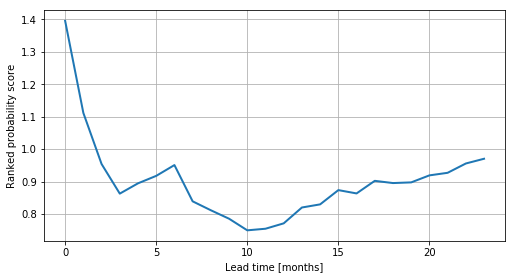

In [508]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(rps['lead_time'],rps,linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Ranked probability score');

# Skill metrics for continuous variables

Here, it makes sense to compare to climatology and to persistence

## Root mean squared error

In [509]:
rms_fcst = skill.compute_rms_error(da_fcst, da_obsv, over_dims='ensemble')

rms_clim = skill.compute_rms_error(da_clim, da_obsv, over_dims=None)

rms_pers = skill.compute_rms_error(da_pers, da_obsv, over_dims=None)

#### Plot as a function of initial month and lead_time

In [510]:
fcst_monthly = rms_fcst.groupby('init_date.month').mean(dim='init_date')

clim_monthly = rms_clim.groupby('init_date.month').mean(dim='init_date')

pers_monthly = rms_pers.groupby('init_date.month').mean(dim='init_date')

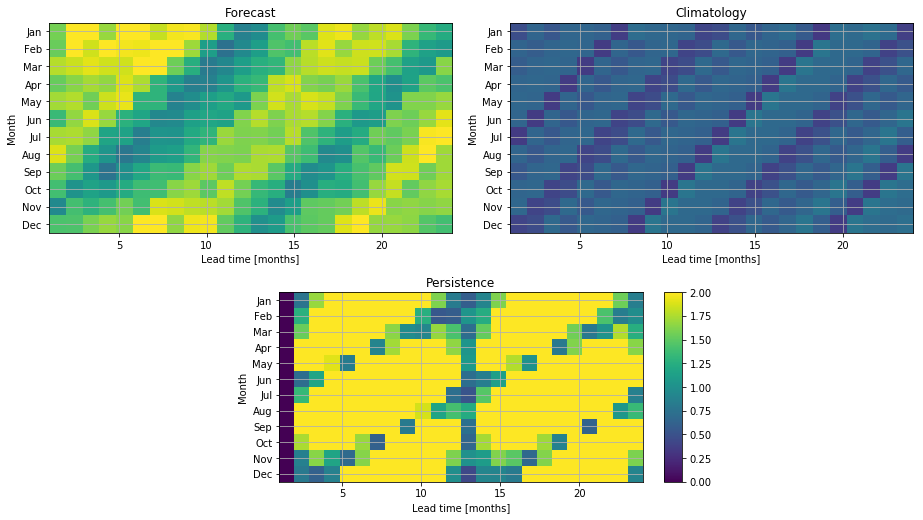

In [511]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
vmin = 0
vmax = 2

fig1 = plt.figure(figsize=(8,9))

ax1 = fig1.add_axes([0.1, 0.5, 0.7, 0.7])
ax1.grid()
cax1 = ax1.imshow(fcst_monthly, extent=[1,24,12.5,0.5], 
                  interpolation='nearest', vmin=vmin, vmax=vmax)
ax1.set_yticks(range(1,13))
ax1.set_yticklabels(months)
ax1.set_xlabel('Lead time [months]')
ax1.set_ylabel('Month')
ax1.set_title('Forecast')

ax2 = fig1.add_axes([0.9, 0.5, 0.7, 0.7])
ax2.grid()
ax2.imshow(clim_monthly, extent=[1,24,12.5,0.5], 
                  interpolation='nearest', vmin=vmin, vmax=vmax)
ax2.set_yticks(range(1,13))
ax2.set_yticklabels(months)
ax2.set_xlabel('Lead time [months]')
ax2.set_ylabel('Month')
ax2.set_title('Climatology')

ax3 = fig1.add_axes([0.5, 0.1, 0.7, 0.7])
ax3.grid()
p3 = ax3.imshow(pers_monthly, extent=[1,24,12.5,0.5], 
                  interpolation='nearest', vmin=vmin, vmax=vmax)
ax3.set_yticks(range(1,13))
ax3.set_yticklabels(months)
ax3.set_xlabel('Lead time [months]')
ax3.set_ylabel('Month')
ax3.set_title('Persistence');

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.3)
plt.colorbar(p3, cax=cax);

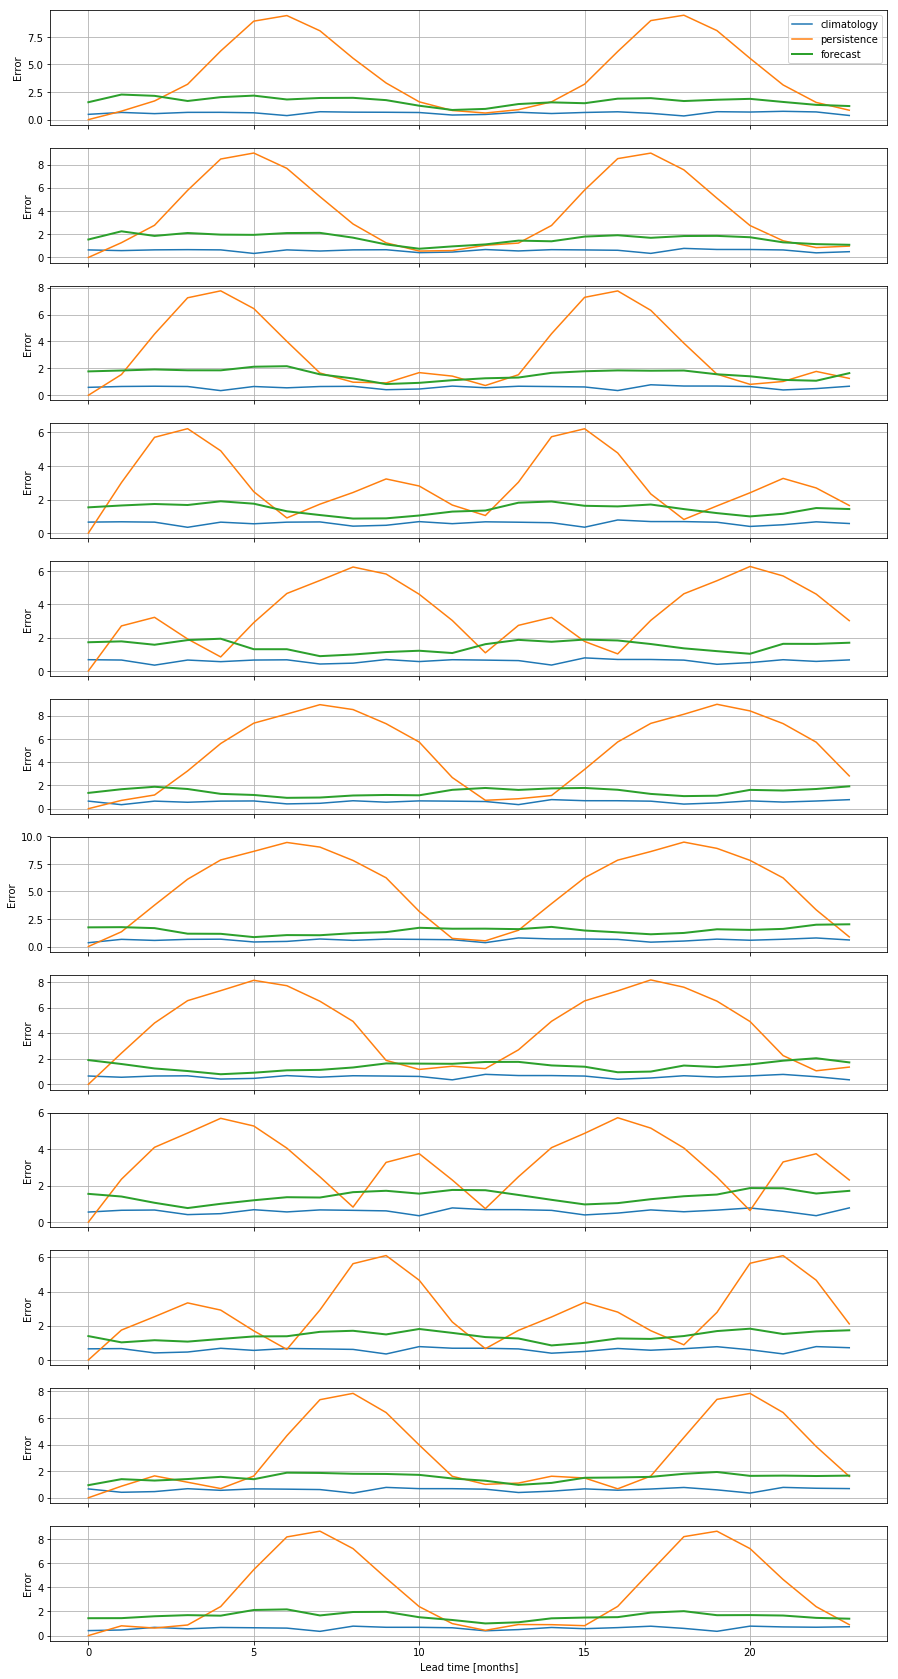

In [512]:
ncol = 1; nrow = 12;
fig, axs = plt.subplots(figsize=(15,30), nrows=nrow, ncols=ncol);

for idx,ax in enumerate(axs.reshape(-1)): 
    ax.grid()
    scale_width = 2.5
    ax.plot(clim_monthly.lead_time, clim_monthly.isel(month=[idx]).squeeze())
    ax.plot(pers_monthly.lead_time, pers_monthly.isel(month=[idx]).squeeze())
    ax.plot(fcst_monthly.lead_time, fcst_monthly.isel(month=[idx]).squeeze(),linewidth=2)

    if idx == 0:
        ax.legend(['climatology','persistence','forecast'])
        
    if idx % ncol == 0:
        ax.set_ylabel('Error')
    else:
        ax.set_yticklabels([])

    if idx / ncol >= nrow - 1:
        ax.set_xlabel('Lead time [months]')
    else:
        ax.set_xticklabels([])

## Multiplicative bias error

In [513]:
mult_bias_fcst = skill.compute_mean_multiplicative_bias(da_fcst, da_obsv, over_dims='ensemble')

mult_bias_clim = skill.compute_mean_multiplicative_bias(da_clim, da_obsv, over_dims=None)

mult_bias_pers = skill.compute_mean_multiplicative_bias(da_pers, da_obsv, over_dims=None)

#### Plot as a function of initial month and lead_time

In [527]:
fcst_monthly = mult_bias_fcst.groupby('init_date.month').mean(dim='init_date')

clim_monthly = mult_bias_clim.groupby('init_date.month').mean(dim='init_date')

pers_monthly = mult_bias_pers.groupby('init_date.month').mean(dim='init_date')

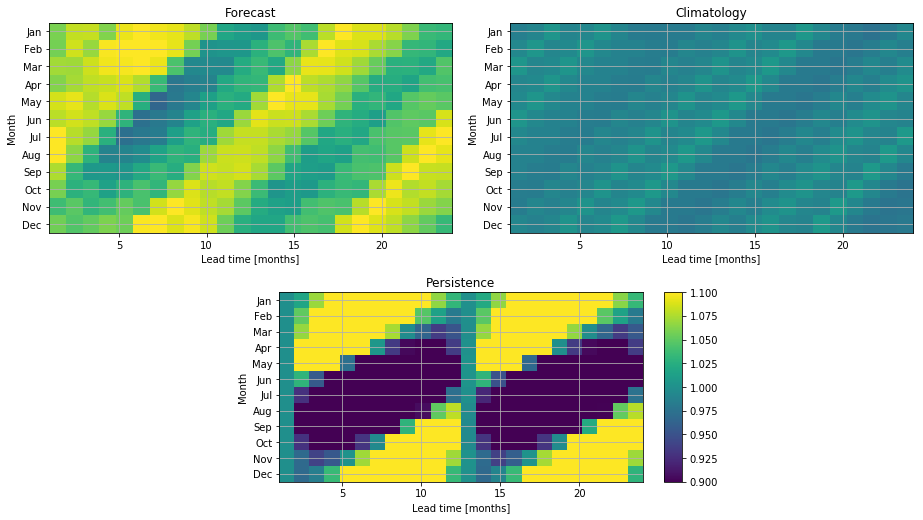

In [528]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
vmin = 0.9
vmax = 1.1

fig1 = plt.figure(figsize=(8,9))

ax1 = fig1.add_axes([0.1, 0.5, 0.7, 0.7])
ax1.grid()
cax1 = ax1.imshow(fcst_monthly, extent=[1,24,12.5,0.5], 
                  interpolation='nearest', vmin=vmin, vmax=vmax)
ax1.set_yticks(range(1,13))
ax1.set_yticklabels(months)
ax1.set_xlabel('Lead time [months]')
ax1.set_ylabel('Month')
ax1.set_title('Forecast')

ax2 = fig1.add_axes([0.9, 0.5, 0.7, 0.7])
ax2.grid()
ax2.imshow(clim_monthly, extent=[1,24,12.5,0.5], 
                  interpolation='nearest', vmin=vmin, vmax=vmax)
ax2.set_yticks(range(1,13))
ax2.set_yticklabels(months)
ax2.set_xlabel('Lead time [months]')
ax2.set_ylabel('Month')
ax2.set_title('Climatology')

ax3 = fig1.add_axes([0.5, 0.1, 0.7, 0.7])
ax3.grid()
p3 = ax3.imshow(pers_monthly, extent=[1,24,12.5,0.5], 
                  interpolation='nearest', vmin=vmin, vmax=vmax)
ax3.set_yticks(range(1,13))
ax3.set_yticklabels(months)
ax3.set_xlabel('Lead time [months]')
ax3.set_ylabel('Month')
ax3.set_title('Persistence');

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.3)
plt.colorbar(p3, cax=cax);

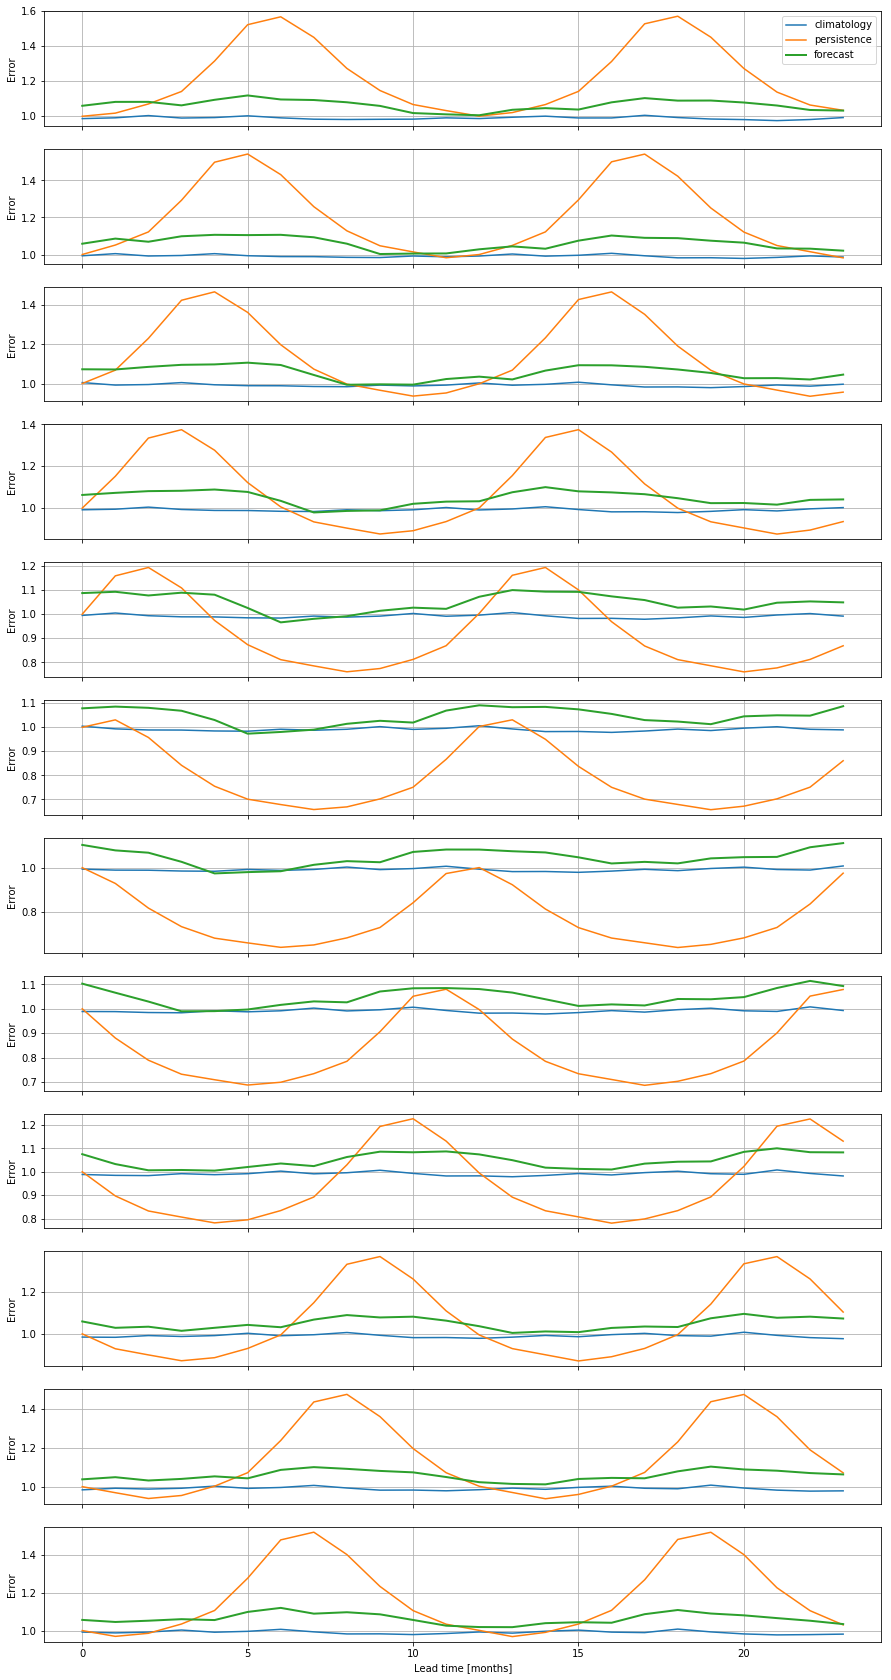

In [516]:
ncol = 1; nrow = 12;
fig, axs = plt.subplots(figsize=(15,30), nrows=nrow, ncols=ncol);

for idx,ax in enumerate(axs.reshape(-1)): 
    ax.grid()
    scale_width = 2.5
    ax.plot(clim_monthly.lead_time, clim_monthly.isel(month=[idx]).squeeze())
    ax.plot(pers_monthly.lead_time, pers_monthly.isel(month=[idx]).squeeze())
    ax.plot(fcst_monthly.lead_time, fcst_monthly.isel(month=[idx]).squeeze(),linewidth=2)

    if idx == 0:
        ax.legend(['climatology','persistence','forecast'])
        
    if idx % ncol == 0:
        ax.set_ylabel('Error')
    else:
        ax.set_yticklabels([])

    if idx / ncol >= nrow - 1:
        ax.set_xlabel('Lead time [months]')
    else:
        ax.set_xticklabels([])

## Correlation coefficient

In [517]:
corrcoef_fcst = skill.compute_Pearson_corrcoef(da_fcst, da_obsv, over_dims=['lead_time','ensemble'])

corrcoef_clim = skill.compute_Pearson_corrcoef(da_clim, da_obsv, over_dims='lead_time')

In [518]:
fcst_monthly = corrcoef_fcst.groupby('init_date.month').mean(dim='init_date')

clim_monthly = corrcoef_clim.groupby('init_date.month').mean(dim='init_date')

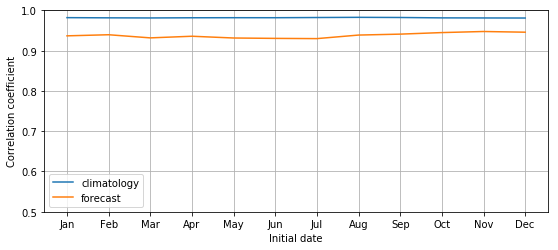

In [519]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig1 = plt.figure(figsize=(10,4))

ax1 = fig1.add_axes([0.1, 0.5, 0.7, 0.7])
ax1.grid()
ax1.plot(clim_monthly['month'],clim_monthly)
ax1.plot(fcst_monthly['month'],fcst_monthly)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(months)
ax1.set_xlabel('Initial date')
ax1.set_ylabel('Correlation coefficient')
ax1.set_ylim(0.5,1)
ax1.legend(['climatology','forecast']);

## Anomaly correlation

In [520]:
corrcoef_fcst = skill.compute_Pearson_corrcoef(da_fcst_anom, da_obsv_anom, 
                                               over_dims=['lead_time','ensemble'], subtract_local_mean=False)

corrcoef_pers = skill.compute_Pearson_corrcoef(da_pers - da_clim, da_obsv_anom, 
                                               over_dims='lead_time', subtract_local_mean=False)

In [521]:
fcst_monthly = corrcoef_fcst.groupby('init_date.month').mean(dim='init_date')

pers_monthly = corrcoef_pers.groupby('init_date.month').mean(dim='init_date')

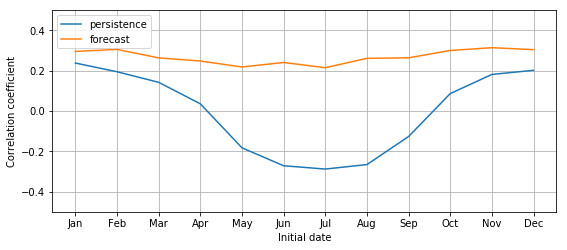

In [522]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig1 = plt.figure(figsize=(10,4))

ax1 = fig1.add_axes([0.1, 0.5, 0.7, 0.7])
ax1.grid()
ax1.plot(pers_monthly['month'],pers_monthly)
ax1.plot(fcst_monthly['month'],fcst_monthly)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(months)
ax1.set_xlabel('Initial date')
ax1.set_ylabel('Correlation coefficient')
ax1.set_ylim(-0.5,0.5);
ax1.legend(['persistence','forecast']);

# Close dask client

In [34]:
# with utils.timer():
#     client.close()

In [489]:
from importlib import reload
utils = reload(utils)
skill = reload(skill)